Observations:

(a) MLP (No Regularization): The MLP without any regularization achieves a smooth decision boundary that effectively captures the nonlinear structure of the XOR problem.

(b) MLP (L1 Regularization): L1 regularization encourages sparsity in weights. As a result, the decision boundary is less flexible than in the unregularized MLP.

(c) MLP (L2 Regularization): L2 regularization promotes smaller weights, producing a smoother decision boundary than L1 regularization. This helps reduce overfitting while still maintaining flexibility to capture the XOR pattern.

(d) Logistic Regression (with Polynomial Features): Introducing non-linear features of degree 2 transforms the decision boundary to a more circular shape, which improves accuracy in capturing the XOR pattern compared to standard logistic regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_xor_label(p):
  # XOR logic: if x * y is negative, return 0, else return 1
  return 1 if p[0] * p[1] < 0 else 0

# Function to generate XOR-labeled data
def classify_xor_data(num_samples: int, noise: float):
    points = []
    for _ in range(num_samples):
        x = np.random.uniform(-5, 5)
        y = np.random.uniform(-5, 5)

        # Padding for x and y
        padding = 0.3
        x += padding if x > 0 else -padding
        y += padding if y > 0 else -padding

        # Adding noise
        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise

        # Getting XOR label
        label = get_xor_label((x + noise_x, y + noise_y))
        points.append([x, y, label])

    return np.array(points)

In [3]:
# Generating dataset
train_data = classify_xor_data(num_samples=200, noise=0.1)
test_data = classify_xor_data(num_samples=200, noise=0.2)

In [4]:
# Plotting function
def plot_xor_data(X,y, title):
    plt.figure(figsize=(6, 6))
    # Plotting the points, using blue for label 1 and orange for label 0
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Label 1', edgecolor='k')
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='orange', label='Label 0', edgecolor='k')

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
X_train = train_data[:, :2]
y_train = train_data[:, 2]
X_test = test_data[:, :2]
y_test = test_data[:, 2]

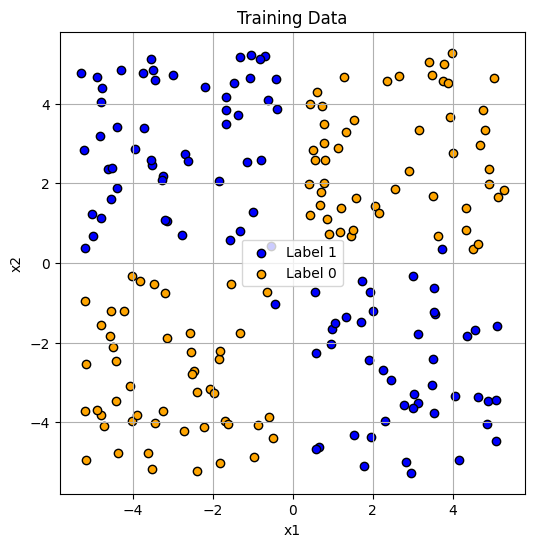

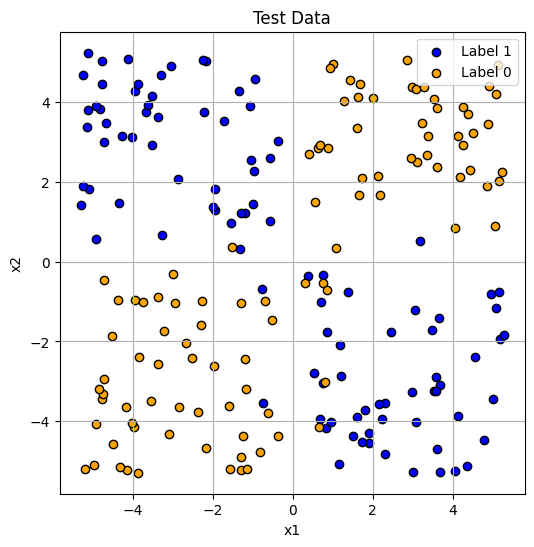

In [6]:
plot_xor_data(X_train, y_train, 'Training Data')
plot_xor_data(X_test, y_test, 'Test Data')

In [7]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [9]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_1 = 10
        hidden_2 = 10
        self.fc1 = nn.Linear(2, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 2)

    def forward(self, x):
        x = x.view(-1, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
model.to(device)
summary(model, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
            Linear-2                   [-1, 10]             110
            Linear-3                    [-1, 2]              22
Total params: 162
Trainable params: 162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [243]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
X_t, X_val, y_t, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

batch_size = 8
# Creating DataLoader for the training set
train_data = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_data, batch_size=batch_size)

# Creating DataLoader for the validation set
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Creating DataLoader for the test set
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [175]:
def train_model(model, criterion, optimizer, train_loader, val_loader, reg_type=None, lambda_reg=0.01, epochs=50):
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Applying regularization
            if reg_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
            elif reg_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculating average training loss
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                # Calculating accuracy
                _, predicted = torch.max(outputs, 1)
                total += y_val.size(0)
                correct += (predicted == y_val).sum().item()

        # Average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = correct / total

        # Printing training and validation results every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    return val_accuracy

In [47]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [254]:
import numpy as np
from itertools import combinations_with_replacement

def polynomial_transform(X, degree):
    n_samples, n_features = X.shape
    # Starting with an array of ones for the intercept term
    poly_features = [np.ones((n_samples, 1))]

    # Generating polynomial features for each degree from 1 to the specified degree
    for d in range(1, degree + 1):
        # Getting all combinations of feature indices with repetition for the current degree
        for combination in combinations_with_replacement(range(n_features), d):
            # Multiply the features as per the combination and add it to the feature list
            feature_product = np.prod([X[:, i] for i in combination], axis=0)
            poly_features.append(feature_product.reshape(-1, 1))

    # Concatenating all the polynomial features horizontally
    return np.hstack(poly_features)

In [241]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(X, y, model,poly=None):
    plt.figure(figsize=(6, 6))

    # Definining the boundaries of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.04),
                         np.arange(y_min, y_max, 0.04))

    grid = np.c_[xx.ravel(), yy.ravel()]
    if(poly):
        grid = polynomial_transform(grid, degree=2)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        _, predicted_classes = torch.max(outputs, 1)

    Z = predicted_classes.cpu().numpy().reshape(xx.shape)


    # Plotting the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['blue', 'orange']))
    plt.contour(xx, yy, Z, colors='black', linewidths=0.2)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', marker='^', edgecolors='k', label='Class 1')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', marker='s', edgecolors='k', label='Class 0')

    # Adding labels and legend
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()
    plt.show()

# (a) MLP with no regularization

In [191]:
mlp = MLP()
mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [192]:
train_model(mlp,criterion,optimizer,train_loader,val_loader,epochs=50)

Epoch 10/50, Train Loss: 0.3967, Val Loss: 0.3836, Val Accuracy: 0.8667
Epoch 20/50, Train Loss: 0.1793, Val Loss: 0.1869, Val Accuracy: 0.9667
Epoch 30/50, Train Loss: 0.1071, Val Loss: 0.1218, Val Accuracy: 0.9833
Epoch 40/50, Train Loss: 0.0747, Val Loss: 0.0919, Val Accuracy: 0.9833
Epoch 50/50, Train Loss: 0.0575, Val Loss: 0.0781, Val Accuracy: 0.9833


0.9833333333333333

In [193]:
evaluate_model(mlp,test_loader)

Accuracy: 0.9600


0.96

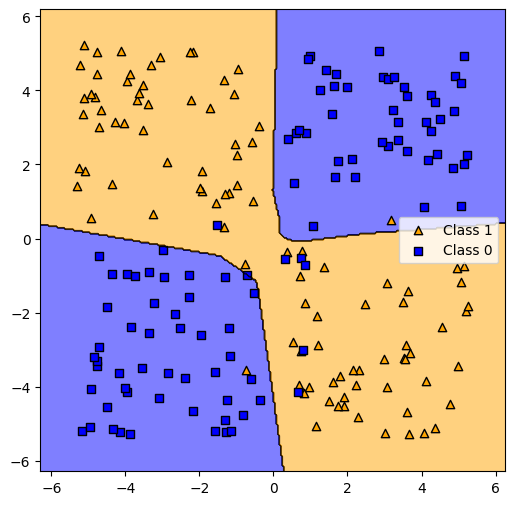

In [194]:
plot_decision_boundary(X_test,y_test,mlp)

# (b) MLP with L1 regularization

In [244]:
# List of L1 penalty coefficients
l1_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L1 penalty coefficient
for l1_penalty in l1_penalties:
    mlp_l1 = MLP()
    mlp_l1.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l1.parameters(), lr=0.001)
    val_accuracy=train_model(mlp_l1,criterion,optimizer,train_loader,val_loader,reg_type='L1',lambda_reg=l1_penalty,epochs=50)

    print(f"L1 penalty: {l1_penalty}, Validation Accuracy: {val_accuracy:.4f}\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l1_penalty
        best_model = mlp_l1

print(f"Best L1 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 10/50, Train Loss: 0.4629, Val Loss: 0.4106, Val Accuracy: 0.8167
Epoch 20/50, Train Loss: 0.2507, Val Loss: 0.1881, Val Accuracy: 1.0000
Epoch 30/50, Train Loss: 0.1585, Val Loss: 0.0970, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.1218, Val Loss: 0.0631, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.1033, Val Loss: 0.0475, Val Accuracy: 1.0000
L1 penalty: 0.001, Validation Accuracy: 1.0000

Epoch 10/50, Train Loss: 0.6613, Val Loss: 0.4371, Val Accuracy: 0.9667
Epoch 20/50, Train Loss: 0.4247, Val Loss: 0.1975, Val Accuracy: 1.0000
Epoch 30/50, Train Loss: 0.3489, Val Loss: 0.1165, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.3241, Val Loss: 0.0895, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.3099, Val Loss: 0.0757, Val Accuracy: 1.0000
L1 penalty: 0.01, Validation Accuracy: 1.0000

Epoch 10/50, Train Loss: 2.0643, Val Loss: 0.6642, Val Accuracy: 0.7667
Epoch 20/50, Train Loss: 1.1388, Val Loss: 0.6930, Val Accuracy: 0.3500
Epoch 30/50, Train Loss: 0.8245, Val Loss

In [245]:
mlp_l1 = MLP()
mlp_l1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_l1.parameters(), lr=0.001)

In [246]:
train_model(mlp_l1,criterion,optimizer,train_loader,val_loader,reg_type='L1',lambda_reg=0.001,epochs=50)

Epoch 10/50, Train Loss: 0.4651, Val Loss: 0.4267, Val Accuracy: 0.9333
Epoch 20/50, Train Loss: 0.2174, Val Loss: 0.1535, Val Accuracy: 1.0000
Epoch 30/50, Train Loss: 0.1425, Val Loss: 0.0778, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.1149, Val Loss: 0.0528, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.1007, Val Loss: 0.0411, Val Accuracy: 1.0000


1.0

In [247]:
evaluate_model(mlp_l1,test_loader)

Accuracy: 0.9550


0.955

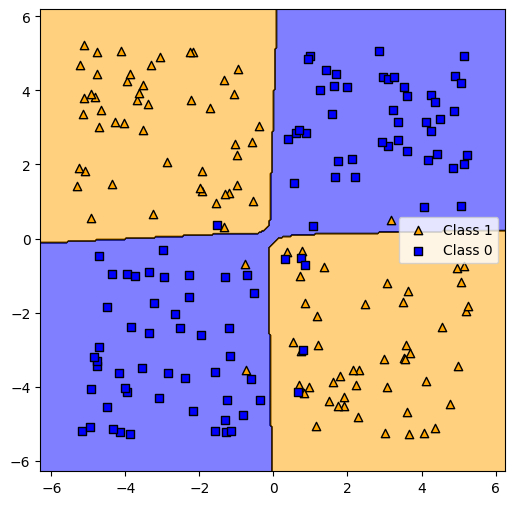

In [248]:
plot_decision_boundary(X_test,y_test,mlp_l1)

# (c) MLP with L2 regularization

In [249]:
# List of L2 penalty coefficients
l2_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L2 penalty coefficient
for l2_penalty in l2_penalties:
    mlp_l2 = MLP()
    mlp_l2.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l2.parameters(), lr=0.001)
    val_accuracy = train_model(mlp_l2,criterion,optimizer,train_loader,val_loader,reg_type='L2',lambda_reg=l2_penalty,epochs=50)

    print(f"L2 penalty: {l2_penalty}, Validation Accuracy: {val_accuracy:.4f}\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l2_penalty
        best_model = mlp_l2

print(f"Best L2 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 10/50, Train Loss: 0.3104, Val Loss: 0.2586, Val Accuracy: 1.0000
Epoch 20/50, Train Loss: 0.1416, Val Loss: 0.1022, Val Accuracy: 1.0000
Epoch 30/50, Train Loss: 0.0975, Val Loss: 0.0613, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.0790, Val Loss: 0.0453, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.0691, Val Loss: 0.0374, Val Accuracy: 1.0000
L2 penalty: 0.001, Validation Accuracy: 1.0000

Epoch 10/50, Train Loss: 0.5880, Val Loss: 0.4948, Val Accuracy: 0.9333
Epoch 20/50, Train Loss: 0.3642, Val Loss: 0.2475, Val Accuracy: 0.9833
Epoch 30/50, Train Loss: 0.2434, Val Loss: 0.1222, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.2118, Val Loss: 0.0810, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.2005, Val Loss: 0.0672, Val Accuracy: 1.0000
L2 penalty: 0.01, Validation Accuracy: 1.0000

Epoch 10/50, Train Loss: 1.0159, Val Loss: 0.5901, Val Accuracy: 0.8000
Epoch 20/50, Train Loss: 0.8080, Val Loss: 0.5606, Val Accuracy: 0.8333
Epoch 30/50, Train Loss: 0.7380, Val Loss

In [250]:
mlp_l2 = MLP()
mlp_l2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_l2.parameters(), lr=0.001)

In [251]:
train_model(mlp_l2,criterion,optimizer,train_loader,val_loader,reg_type='L2',lambda_reg=0.001,epochs=50)

Epoch 10/50, Train Loss: 0.4241, Val Loss: 0.4015, Val Accuracy: 1.0000
Epoch 20/50, Train Loss: 0.1945, Val Loss: 0.1672, Val Accuracy: 1.0000
Epoch 30/50, Train Loss: 0.1202, Val Loss: 0.0932, Val Accuracy: 1.0000
Epoch 40/50, Train Loss: 0.0914, Val Loss: 0.0635, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.0774, Val Loss: 0.0488, Val Accuracy: 1.0000


1.0

In [252]:
evaluate_model(mlp_l2,test_loader)

Accuracy: 0.9550


0.955

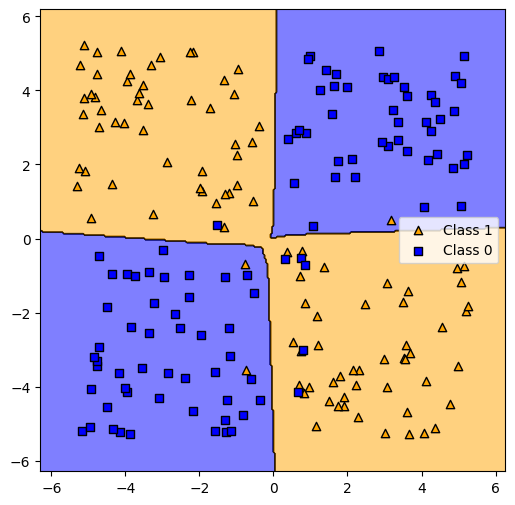

In [253]:
plot_decision_boundary(X_test,y_test,mlp_l2)

# (d) Logistic regression with additional features

In [255]:
X_train_poly = polynomial_transform(X_train, degree=2)
X_test_poly = polynomial_transform(X_test, degree=2)

In [256]:
X_train_poly.shape

(200, 6)

In [257]:
X_train_poly_tensor = torch.tensor(X_train_poly, dtype=torch.float32).to(device)
X_test_poly_tensor = torch.tensor(X_test_poly, dtype=torch.float32).to(device)

In [266]:
batch_size = 8
X_t, X_val, y_t, y_val = train_test_split(X_train_poly_tensor, y_train_tensor, test_size=0.3, random_state=42)
train_data = TensorDataset(X_t, y_t)
train_loader = DataLoader(train_data, batch_size=batch_size)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test_poly_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [267]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 2)

    def forward(self, x):
        x = x.view(-1,6)
        return self.linear(x)

In [268]:
model = LogisticRegression(input_dim=X_train_poly_tensor.shape[1])
model.to(device)
summary(model, input_size=(1,6))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]              14
Total params: 14
Trainable params: 14
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [269]:
logistic = LogisticRegression(input_dim=X_train_poly.shape[1])
logistic.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic.parameters(), lr=0.001)

In [270]:
train_model(logistic,criterion,optimizer,train_loader,val_loader,epochs=50)

Epoch 10/50, Train Loss: 0.5486, Val Loss: 0.4220, Val Accuracy: 0.8333
Epoch 20/50, Train Loss: 0.2725, Val Loss: 0.1918, Val Accuracy: 0.9667
Epoch 30/50, Train Loss: 0.2109, Val Loss: 0.1459, Val Accuracy: 0.9833
Epoch 40/50, Train Loss: 0.1780, Val Loss: 0.1242, Val Accuracy: 1.0000
Epoch 50/50, Train Loss: 0.1554, Val Loss: 0.1103, Val Accuracy: 1.0000


1.0

In [271]:
evaluate_model(logistic,test_loader)

Accuracy: 0.9500


0.95

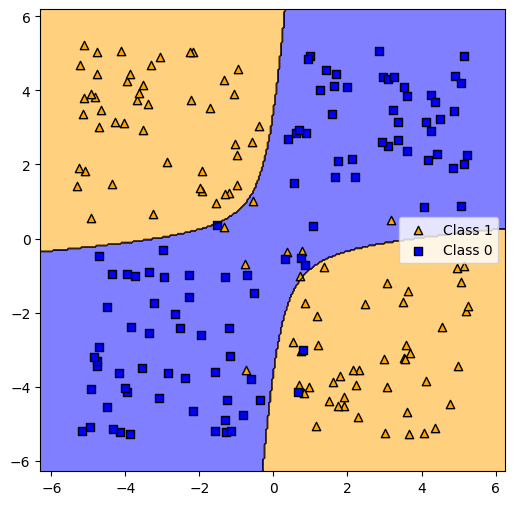

In [272]:
plot_decision_boundary(X_test, y_test, logistic, poly=True)